In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

In [2]:
df=pd.read_csv("fleet_train.csv")
df.head(50)

,Maintenance_flag,record_id,Measurement_timestamp,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Intake_Manifold_Pressure,Engine_RPM,Speed_OBD,...,GPS_Altitude,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,Accel_Ssor_Total,CO2_in_g_per_km_Inst,Trip_Time_journey,fleetid,truckid,Region
0,0,8229,22FEB16:18:18:15,35,249.188875,21.568628,88,116,1115.5,35,...,164,2.755716,310.26200,2.351502,0.045858,62.197178,11539,Fleet_00713F1,Truck_0711X1,1
1,0,932,22FEB16:16:16:38,142,243.236572,20.392157,88,135,1782.5,142,...,436,5.511435,161.02463,1.244649,0.043655,32.920940,4242,Fleet_01213F1,Truck_0081X1,1
2,0,836,22FEB16:16:15:02,128,244.015378,43.529410,81,109,1588.0,128,...,508,1.740453,158.23788,2.124100,0.073833,56.182410,4146,Fleet_01213F1,Truck_0081X1,1
3,0,570,22FEB16:16:10:36,117,244.627297,99.607840,89,128,1899.5,117,...,618,4.496170,148.82233,0.000000,0.059974,0.000000,3880,Fleet_01013F1,Truck_0171X1,1
4,0,7098,22FEB16:17:59:24,98,245.684248,73.333336,89,123,1230.5,98,...,154,3.770981,296.00378,4.031921,-0.019424,106.644250,10408,Fleet_00413F1,Truck_0641X1,2
5,0,4930,22FEB16:17:23:16,96,245.795506,0.000000,83,115,1175.0,96,...,216,2.610680,252.72640,0.000000,-0.117610,0.000000,8240,Fleet_00713F1,Truck_0421X1,1
6,0,7459,22FEB16:18:05:25,55,248.076295,39.607845,87,110,1324.0,55,...,156,1.885490,304.47766,3.408120,0.041098,90.144720,10769,Fleet_00213F1,Truck_0791X1,2
7,0,121,22FEB16:16:03:07,58,247.909408,38.823530,88,105,1410.5,58,...,789,1.160302,137.92912,0.000000,0.008018,26.569048,3431,Fleet_01213F1,Truck_0021X1,1
8,0,3594,22FEB16:17:01:00,114,244.794184,14.117647,90,113,1403.0,114,...,502,2.320604,211.98659,0.000000,-0.041719,19.719515,6904,Fleet_00913F1,Truck_0491X1,1
9,0,976,22FEB16:16:17:22,157,242.402137,54.117650,88,137,1932.0,157,...,438,5.801510,162.94577,3.422803,-0.066723,90.533070,4286,Fleet_01213F1,Truck_0081X1,1


In [3]:
df.isnull().sum()

Maintenance_flag             0
record_id                    0
Measurement_timestamp        0
Vehicle_speed_sensor         0
Vibration                    0
Engine_Load                  0
Engine_Coolant_Temp          0
Intake_Manifold_Pressure     0
Engine_RPM                   0
Speed_OBD                    0
Intake_Air_Temp              0
Mass_Air_Flow_Rate           0
Throttle_Pos_Manifold        0
Voltage_Control_Module       0
Ambient_air_temp             0
Accel_Pedal_Pos_D            0
Engine_Oil_Temp              0
Speed_GPS                    0
GPS_Longitude                0
GPS_Latitude                 0
GPS_Bearing                  0
GPS_Altitude                 0
Turbo_Boost_And_Vcm_Gauge    0
Trip_Distance                0
Litres_Per_100km_Inst        0
Accel_Ssor_Total             0
CO2_in_g_per_km_Inst         0
Trip_Time_journey            0
fleetid                      0
truckid                      0
Region                       0
dtype: int64

In [4]:
df.drop(['record_id','fleetid','truckid','Region'], axis=1, inplace=True)

In [5]:
features_to_normalize = [
    'Engine_Load', 'Engine_RPM', 'Engine_Coolant_Temp', 'Vibration',
    'Mass_Air_Flow_Rate', 'Engine_Oil_Temp', 'Throttle_Pos_Manifold',
    'Accel_Ssor_Total', 'Trip_Distance', 'Trip_Time_journey', 'Turbo_Boost_And_Vcm_Gauge'
]

In [6]:
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# df['engine_health_score'] = (df['Engine_Load'] + df['Engine_RPM'] + df['Engine_Coolant_Temp']) / 3
# df['battery_health_score'] = (df['Mass_Air_Flow_Rate'] + df['Engine_Oil_Temp']) / 2
# df['vibration_score'] = df['Vibration']
df.head(50)

,Maintenance_flag,Measurement_timestamp,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Intake_Manifold_Pressure,Engine_RPM,Speed_OBD,Intake_Air_Temp,...,GPS_Longitude,GPS_Latitude,GPS_Bearing,GPS_Altitude,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,Accel_Ssor_Total,CO2_in_g_per_km_Inst,Trip_Time_journey
0,0,22FEB16:18:18:15,35,0.811828,0.216535,0.600000,116,0.231587,35,10,...,9.141699,48.932757,75.2,164,0.091503,0.993639,2.351502,0.653445,62.197178,0.986216
1,0,22FEB16:16:16:38,142,0.236559,0.204724,0.600000,135,0.577541,142,16,...,9.885384,48.494790,274.4,436,0.215686,0.144925,1.244649,0.651602,32.920940,0.111591
2,0,22FEB16:16:15:02,128,0.311828,0.437008,0.133333,109,0.476660,128,9,...,9.648060,48.479574,257.1,508,0.045752,0.129077,2.124100,0.676852,56.182410,0.100084
3,0,22FEB16:16:10:36,117,0.370968,1.000000,0.666667,128,0.638226,117,13,...,8.344292,48.611216,330.7,618,0.169935,0.075531,0.000000,0.665256,0.000000,0.068201
4,0,22FEB16:17:59:24,98,0.473118,0.736221,0.666667,123,0.291234,98,9,...,7.746547,48.377976,3.0,154,0.137255,0.912552,4.031921,0.598824,106.644250,0.850653
5,0,22FEB16:17:23:16,96,0.483871,0.000000,0.266667,115,0.262448,96,9,...,9.722799,48.713457,274.8,216,0.084967,0.666434,0.000000,0.516672,0.000000,0.590795
6,0,22FEB16:18:05:25,55,0.704301,0.397638,0.533333,110,0.339730,55,10,...,8.111984,48.240487,116.2,156,0.052288,0.960743,3.408120,0.649463,90.144720,0.893923
7,0,22FEB16:16:03:07,58,0.688172,0.389764,0.600000,105,0.384595,58,10,...,8.810880,48.702156,254.9,789,0.019608,0.013581,0.000000,0.621785,26.569048,0.014383
8,0,22FEB16:17:01:00,114,0.387097,0.141732,0.733333,113,0.380705,114,11,...,8.849629,48.668646,287.6,502,0.071895,0.434746,0.000000,0.580170,19.719515,0.430660
9,0,22FEB16:16:17:22,157,0.155914,0.543307,0.600000,137,0.655083,157,11,...,10.045050,48.487620,273.3,438,0.228758,0.155851,3.422803,0.559249,90.533070,0.116864


In [7]:
def calculate_condition_score(row):
    engine_health_score = (row['Engine_Load'] + row['Engine_RPM'] + row['Engine_Coolant_Temp']) / 3
    usage_severity = row['Engine_Load'] * (row['Trip_Distance'] + row['Trip_Time_journey'])
    anomaly_flag = int((row['Vibration'] > 0.7) or (row['Engine_Coolant_Temp'] > 0.8))
    condition_score = 0.5 * engine_health_score + 0.3 * usage_severity + 0.2 * anomaly_flag
    return condition_score

df['Condition_Score'] = df.apply(calculate_condition_score, axis=1)

df.head()


,Maintenance_flag,Measurement_timestamp,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Intake_Manifold_Pressure,Engine_RPM,Speed_OBD,Intake_Air_Temp,...,GPS_Latitude,GPS_Bearing,GPS_Altitude,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,Accel_Ssor_Total,CO2_in_g_per_km_Inst,Trip_Time_journey,Condition_Score
0,0,22FEB16:18:18:15,35,0.811828,0.216535,0.600000,116,0.231587,35,10,...,48.932757,75.2,164,0.091503,0.993639,2.351502,0.653445,62.197178,0.986216,0.503300
1,0,22FEB16:16:16:38,142,0.236559,0.204724,0.600000,135,0.577541,142,16,...,48.494790,274.4,436,0.215686,0.144925,1.244649,0.651602,32.920940,0.111591,0.246132
2,0,22FEB16:16:15:02,128,0.311828,0.437008,0.133333,109,0.476660,128,9,...,48.479574,257.1,508,0.045752,0.129077,2.124100,0.676852,56.182410,0.100084,0.204544
3,0,22FEB16:16:10:36,117,0.370968,1.000000,0.666667,128,0.638226,117,13,...,48.611216,330.7,618,0.169935,0.075531,0.000000,0.665256,0.000000,0.068201,0.427268
4,0,22FEB16:17:59:24,98,0.473118,0.736221,0.666667,123,0.291234,98,9,...,48.377976,3.0,154,0.137255,0.912552,4.031921,0.598824,106.644250,0.850653,0.671786


In [8]:
def assign_priority(score):
    if score > 0.70:
        return 'Critical'
    elif score > 0.45:
        return 'Moderate'
    else:
        return 'Low'

In [9]:
df['Priority'] = df['Condition_Score'].apply(assign_priority)
# df.to_csv('fleet_train_priorities.csv', index=False)
df.head(50)

,Maintenance_flag,Measurement_timestamp,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Intake_Manifold_Pressure,Engine_RPM,Speed_OBD,Intake_Air_Temp,...,GPS_Bearing,GPS_Altitude,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,Accel_Ssor_Total,CO2_in_g_per_km_Inst,Trip_Time_journey,Condition_Score,Priority
0,0,22FEB16:18:18:15,35,0.811828,0.216535,0.600000,116,0.231587,35,10,...,75.2,164,0.091503,0.993639,2.351502,0.653445,62.197178,0.986216,0.503300,Moderate
1,0,22FEB16:16:16:38,142,0.236559,0.204724,0.600000,135,0.577541,142,16,...,274.4,436,0.215686,0.144925,1.244649,0.651602,32.920940,0.111591,0.246132,Low
2,0,22FEB16:16:15:02,128,0.311828,0.437008,0.133333,109,0.476660,128,9,...,257.1,508,0.045752,0.129077,2.124100,0.676852,56.182410,0.100084,0.204544,Low
3,0,22FEB16:16:10:36,117,0.370968,1.000000,0.666667,128,0.638226,117,13,...,330.7,618,0.169935,0.075531,0.000000,0.665256,0.000000,0.068201,0.427268,Low
4,0,22FEB16:17:59:24,98,0.473118,0.736221,0.666667,123,0.291234,98,9,...,3.0,154,0.137255,0.912552,4.031921,0.598824,106.644250,0.850653,0.671786,Moderate
5,0,22FEB16:17:23:16,96,0.483871,0.000000,0.266667,115,0.262448,96,9,...,274.8,216,0.084967,0.666434,0.000000,0.516672,0.000000,0.590795,0.088186,Low
6,0,22FEB16:18:05:25,55,0.704301,0.397638,0.533333,110,0.339730,55,10,...,116.2,156,0.052288,0.960743,3.408120,0.649463,90.144720,0.893923,0.633029,Moderate
7,0,22FEB16:16:03:07,58,0.688172,0.389764,0.600000,105,0.384595,58,10,...,254.9,789,0.019608,0.013581,0.000000,0.621785,26.569048,0.014383,0.232330,Low
8,0,22FEB16:17:01:00,114,0.387097,0.141732,0.733333,113,0.380705,114,11,...,287.6,502,0.071895,0.434746,0.000000,0.580170,19.719515,0.430660,0.246092,Low
9,0,22FEB16:16:17:22,157,0.155914,0.543307,0.600000,137,0.655083,157,11,...,273.3,438,0.228758,0.155851,3.422803,0.559249,90.533070,0.116864,0.344182,Low


In [10]:
df.isnull().sum()

Maintenance_flag             0
Measurement_timestamp        0
Vehicle_speed_sensor         0
Vibration                    0
Engine_Load                  0
Engine_Coolant_Temp          0
Intake_Manifold_Pressure     0
Engine_RPM                   0
Speed_OBD                    0
Intake_Air_Temp              0
Mass_Air_Flow_Rate           0
Throttle_Pos_Manifold        0
Voltage_Control_Module       0
Ambient_air_temp             0
Accel_Pedal_Pos_D            0
Engine_Oil_Temp              0
Speed_GPS                    0
GPS_Longitude                0
GPS_Latitude                 0
GPS_Bearing                  0
GPS_Altitude                 0
Turbo_Boost_And_Vcm_Gauge    0
Trip_Distance                0
Litres_Per_100km_Inst        0
Accel_Ssor_Total             0
CO2_in_g_per_km_Inst         0
Trip_Time_journey            0
Condition_Score              0
Priority                     0
dtype: int64

In [11]:
df['Overstrain_Risk'] = 0.5 * df['Engine_Load'] + 0.5 * df['Engine_RPM']
df['Heat_Dissipation_Risk'] = 0.4 * df['Engine_Coolant_Temp'] + 0.6 * df['Engine_Oil_Temp']
df['Power_Failure_Risk'] = 0.5 * df['Mass_Air_Flow_Rate'] + 0.5 * df['Turbo_Boost_And_Vcm_Gauge']

def assign_failure_label(row):
    if row['Condition_Score'] < 0.3:
        return 'No Failure'
    else:
        risks = {
            'Overstrain Failure': row['Overstrain_Risk'],
            'Heat Dissipation Failure': row['Heat_Dissipation_Risk'],
            'Power Failure': row['Power_Failure_Risk']
        }
        return max(risks, key=risks.get)

df['Failure_Type'] = df.apply(assign_failure_label, axis=1)

df['Failure_Type'].value_counts()

Failure_Type
Heat Dissipation Failure    4052
No Failure                  2405
Overstrain Failure          1016
Power Failure                 31
Name: count, dtype: int64

In [12]:
df[[
    'Engine_Load', 'Engine_RPM', 'Engine_Coolant_Temp', 'Vibration',
    'Mass_Air_Flow_Rate', 'Engine_Oil_Temp', 'Throttle_Pos_Manifold',
    'Accel_Ssor_Total', 'Trip_Distance', 'Trip_Time_journey']]

,Engine_Load,Engine_RPM,Engine_Coolant_Temp,Vibration,Mass_Air_Flow_Rate,Engine_Oil_Temp,Throttle_Pos_Manifold,Accel_Ssor_Total,Trip_Distance,Trip_Time_journey
0,0.216535,0.231587,0.600000,0.811828,0.111290,0.500000,0.977941,0.653445,0.993639,0.986216
1,0.204724,0.577541,0.600000,0.236559,0.263722,0.500000,0.977941,0.651602,0.144925,0.111591
2,0.437008,0.476660,0.133333,0.311828,0.189380,0.071429,0.977941,0.676852,0.129077,0.100084
3,1.000000,0.638226,0.666667,0.370968,0.277822,0.642857,0.977941,0.665256,0.075531,0.068201
4,0.736221,0.291234,0.666667,0.473118,0.140741,0.500000,0.977941,0.598824,0.912552,0.850653
...,...,...,...,...,...,...,...,...,...,...
7499,0.173228,0.326245,0.666667,0.543011,0.144221,0.642857,0.970588,0.564160,0.339978,0.357905
7500,0.000000,0.253890,0.733333,0.489247,0.136546,0.714286,0.977941,0.558672,0.223546,0.222462
7501,0.559055,0.470176,0.666667,0.645161,0.216867,0.571429,0.779412,0.627092,0.883545,0.827760
7502,0.464567,0.385373,0.533333,0.596774,0.162874,0.357143,0.977941,0.534757,0.775144,0.699389


In [13]:
df

,Maintenance_flag,Measurement_timestamp,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Intake_Manifold_Pressure,Engine_RPM,Speed_OBD,Intake_Air_Temp,...,Litres_Per_100km_Inst,Accel_Ssor_Total,CO2_in_g_per_km_Inst,Trip_Time_journey,Condition_Score,Priority,Overstrain_Risk,Heat_Dissipation_Risk,Power_Failure_Risk,Failure_Type
0,0,22FEB16:18:18:15,35,0.811828,0.216535,0.600000,116,0.231587,35,10,...,2.351502,0.653445,62.197178,0.986216,0.503300,Moderate,0.224061,0.540000,0.101396,Heat Dissipation Failure
1,0,22FEB16:16:16:38,142,0.236559,0.204724,0.600000,135,0.577541,142,16,...,1.244649,0.651602,32.920940,0.111591,0.246132,Low,0.391133,0.540000,0.239704,No Failure
2,0,22FEB16:16:15:02,128,0.311828,0.437008,0.133333,109,0.476660,128,9,...,2.124100,0.676852,56.182410,0.100084,0.204544,Low,0.456834,0.096190,0.117566,No Failure
3,0,22FEB16:16:10:36,117,0.370968,1.000000,0.666667,128,0.638226,117,13,...,0.000000,0.665256,0.000000,0.068201,0.427268,Low,0.819113,0.652381,0.223879,Overstrain Failure
4,0,22FEB16:17:59:24,98,0.473118,0.736221,0.666667,123,0.291234,98,9,...,4.031921,0.598824,106.644250,0.850653,0.671786,Moderate,0.513727,0.566667,0.138998,Heat Dissipation Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7499,1,22FEB16:16:50:53,85,0.543011,0.173228,0.666667,106,0.326245,85,10,...,2.500408,0.564160,66.135735,0.357905,0.230625,Low,0.249737,0.652381,0.085183,No Failure
7500,0,22FEB16:16:32:03,95,0.489247,0.000000,0.733333,109,0.253890,95,12,...,0.000000,0.558672,0.000000,0.222462,0.164537,Low,0.126945,0.721905,0.091149,No Failure
7501,1,22FEB16:17:56:13,66,0.645161,0.559055,0.666667,126,0.470176,66,13,...,6.450333,0.627092,170.611180,0.827760,0.569664,Moderate,0.514616,0.609524,0.186865,Heat Dissipation Failure
7502,1,22FEB16:17:38:22,75,0.596774,0.464567,0.533333,109,0.385373,75,8,...,3.525263,0.534757,93.243150,0.699389,0.436051,Low,0.424970,0.427619,0.104313,Heat Dissipation Failure


count    7504.000000
mean        0.385747
std         0.173861
min         0.051135
25%         0.247457
50%         0.382012
75%         0.498125
max         1.095487
Name: Condition_Score, dtype: float64


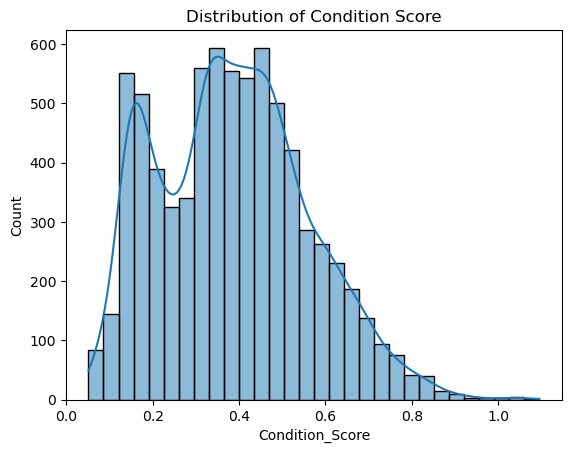

In [14]:
# Check summary statistics
print(df['Condition_Score'].describe())

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['Condition_Score'], bins=30, kde=True)
plt.title('Distribution of Condition Score')
plt.show()


In [19]:
from sklearn.model_selection import train_test_split
x=df.drop(columns=['Failure_Type'])
y=df['Failure_Type']

In [20]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
y=lb.fit_transform(y)

In [22]:
xtrain,xtest, ytrain, ytest=train_test_split(x,y,test_size=0.3,random_state=42)
train = lgb.Dataset(xtrain,label=ytrain)
test=lgb.Dataset(xtest,label=ytest)


In [24]:
params = {
    'objective': 'multiclass',
    'num_class': len(lb.classes_),  
    'boosting_type': 'gbdt', 
    'metric': 'multi_logloss', 
    'learning_rate': 0.1,
    'max_depth': -1,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

In [28]:
lgb_model = lgb.train(
    params,
    train,
    num_boost_round=200,  
    valid_sets=[train, test],
    # early_stopping_rounds=20,  # Early stopping to prevent overfitting
    # verbose_eval=10
)

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: Measurement_timestamp: object, Priority: object